In [2]:
import tensorflow as tf
print(tf.__version__)          # Should be 2.12.0
print(tf.keras.__version__)    # Should be 2.12.0


2.12.0
2.12.0


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image
import numpy as np 
import pandas as pd 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import keras_tuner as kt

In [65]:
# Load the datasets
df = pd.read_csv("albums_genres_grouped.csv")  # Main dataset with album details
skin_df = pd.read_csv("skin_percentages.csv")  # Skin percentage dataset
nudity_df = pd.read_csv("nudity_detection_results.csv")  # Nudity detection results dataset
features_df = pd.read_csv("album_features/album_clip_features_combined.csv")  # Additional features dataset

# Merge the datasets using 'album_id' (ensure album_id is present in each)
merged_df = df.merge(skin_df, on="album_id", how="left")
merged_df = merged_df.merge(nudity_df, on="album_id", how="left")
merged_df = merged_df.merge(features_df, on="album_id", how="left")

# Print the merged dataframe to check the columns
print(merged_df.head())

KeyError: 'album_id'

In [66]:
# Assuming df contains album_id, create a column for the image filenames
df['image_filename'] = df['album_id'].apply(lambda x: f"image_{x}.jpg")

# Verify that the image filenames are correct
print(df[['album_id', 'image_filename']].head())

                 album_id                    image_filename
0  0NGHR9zjS5eFFlqtClA9VV  image_0NGHR9zjS5eFFlqtClA9VV.jpg
1  2fenSS68JI1h4Fo296JfGr  image_2fenSS68JI1h4Fo296JfGr.jpg
2  0sOeI7pbAmIc8aDFyvkBUW  image_0sOeI7pbAmIc8aDFyvkBUW.jpg
3  6n9DKpOxwifT5hOXtgLZSL  image_6n9DKpOxwifT5hOXtgLZSL.jpg
4  2QRedhP5RmKJiJ1i8VgDGR  image_2QRedhP5RmKJiJ1i8VgDGR.jpg


In [4]:
# --- CONFIG ---
image_folder = "images"
image_size = (64, 64)
label_column = "genre_condensed"  # 👈 use this for labels

# --- Load CSV ---
df = pd.read_csv("albums_genres_grouped.csv")

# Add matching filenames like image_0.jpg, image_1.jpg, etc.
df['image_filename'] = df.index.map(lambda i: f"image_{i}.jpg")

# Keep only rows where the image file exists
df = df[df['image_filename'].apply(lambda x: os.path.isfile(os.path.join(image_folder, x)))]
print("Filtered DataFrame shape:", df.shape)

# --- Load images and labels ---
X, y = [], []

for _, row in df.iterrows():
    path = os.path.join(image_folder, row['image_filename'])
    try:
        img = Image.open(path).resize(image_size)
        img_array = np.array(img) / 255.0
        X.append(img_array)
        y.append(row[label_column])  # ✅ using genre_condensed
    except Exception as e:
        print(f"Error loading {path}: {e}")

X = np.array(X)
y = np.array(y)

print("Loaded images:", X.shape)
print("Sample labels:", y[:5])



Filtered DataFrame shape: (1480, 11)
Loaded images: (1480, 64, 64, 3)
Sample labels: ['relaxed' 'country/folk' 'country/folk' 'rap/hip hop' 'rap/hip hop']


In [3]:
print("X dtype:", X.dtype)
print("X shape:", X.shape)
print("X size (MB):", X.nbytes / (1024 ** 2))


X dtype: float64
X shape: (1480, 64, 64, 3)
X size (MB): 138.75


In [5]:


X = X.astype(np.float32)

print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print("Labels encoded.")

print("Splitting train/val...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)
print("Data split complete.")

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Classes:", label_encoder.classes_)


Encoding labels...
Labels encoded.
Splitting train/val...
Data split complete.
Train shape: (1184, 64, 64, 3)
Validation shape: (296, 64, 64, 3)
Classes: ['country/folk' 'electronic' 'indie' 'k-pop' 'kids' 'latin' 'metal' 'pop'
 'r&b' 'rap/hip hop' 'reggae' 'relaxed' 'religious' 'rock' 'soul/jazz'
 'unknown']


In [58]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='softmax')  # Output for 16 classes
])


optimizer = Adam(learning_rate=0.00005)  # Lower the learning rate

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 128)      

In [59]:
datagen = ImageDataGenerator(
    rotation_range=40,   # Increase the range
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.8, 1.2]
)

datagen.fit(X_train)

In [60]:
# --- Early Stopping to Prevent Overfitting ---
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [61]:
# Compute class weights based on the imbalanced distribution
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Automatically balance the weights
    classes=np.unique(y_encoded),  # Unique classes
    y=y_encoded  # The labels
)

# Convert to a dictionary, as Keras requires this format
class_weight_dict = dict(enumerate(class_weights))

# Print class weights for reference
print(class_weight_dict)

{0: 0.5196629213483146, 1: 1.1419753086419753, 2: 0.9840425531914894, 3: 4.404761904761905, 4: 2.642857142857143, 5: 0.7007575757575758, 6: 2.010869565217391, 7: 0.38702928870292885, 8: 1.2671232876712328, 9: 0.28637770897832815, 10: 2.371794871794872, 11: 1.1708860759493671, 12: 3.7, 13: 1.4919354838709677, 14: 2.102272727272727, 15: 10.277777777777779}


In [55]:
unique, counts = np.unique(y_encoded, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

Class distribution: {0: 178, 1: 81, 2: 94, 3: 21, 4: 35, 5: 132, 6: 46, 7: 239, 8: 73, 9: 323, 10: 39, 11: 79, 12: 25, 13: 62, 14: 44, 15: 9}


In [62]:

# --- Model Training ---
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


2025-04-18 12:18:24.597661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - 10s 242ms/step - loss: 4.8980 - accuracy: 0.1892 - val_loss: 3.0312 - val_accuracy: 0.2230
Epoch 2/50
37/37 [==============================] - 9s 229ms/step - loss: 2.6731 - accuracy: 0.2128 - val_loss: 2.7400 - val_accuracy: 0.2196
Epoch 3/50
37/37 [==============================] - 8s 229ms/step - loss: 2.5468 - accuracy: 0.2086 - val_loss: 2.7542 - val_accuracy: 0.2162
Epoch 4/50
37/37 [==============================] - 9s 236ms/step - loss: 2.5325 - accuracy: 0.2230 - val_loss: 2.6166 - val_accuracy: 0.2196


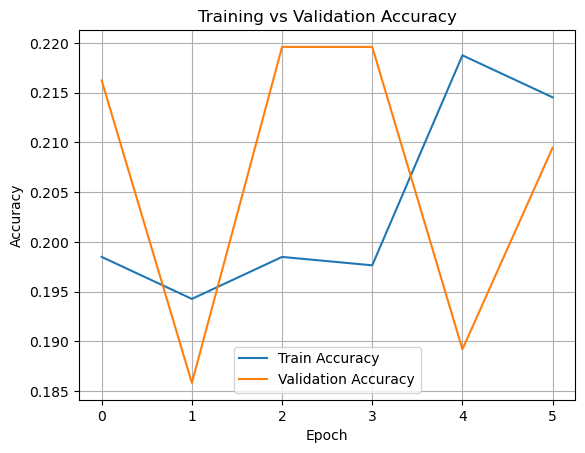

10/10 [==============================] - 1s 77ms/step - loss: 2.5328 - accuracy: 0.2196
Final Validation Accuracy: 0.2196


In [50]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_acc:.4f}")


In [41]:
# Define the model function with hyperparameters
def build_model(hp):
    model = models.Sequential()

    # Convolutional layers with tunable filters and kernel size
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(64, 64, 3)
    ))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu'
    ))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())

    # Dense layers with tunable units
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    model.add(layers.Dense(16, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [42]:
tuner = kt.Hyperband(
    build_model,  # Hypermodel function
    objective='val_accuracy',  # What we're trying to optimize
    max_epochs=10,  # Max number of epochs per trial
    factor=3,  # Factor to increase resources at each step
    directory='my_dir',  # Where to save results
    project_name='hyperparameter_tuning'
)


In [43]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.23648647964000702

Best val_accuracy So Far: 0.2702702581882477
Total elapsed time: 00h 11m 29s


In [44]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8